In [1]:
import numpy as np
import matplotlib.pyplot as plt
from asoh.models.ecm import (EquivalentCircuitModel,
                             ECMASOH,
                             ECMInput,
                             ECMMeasurement,
                             ECMTransientVector)

In [2]:
# Establish models
rint = EquivalentCircuitModel(use_series_capacitor=False,
                              number_RC_components=0,
                              current_behavior='constant')
thenevin = EquivalentCircuitModel(use_series_capacitor=False,
                                  number_RC_components=1,
                                  current_behavior='constant')
pngv = EquivalentCircuitModel(use_series_capacitor=True,
                              number_RC_components=2,
                              current_behavior='linear')
models = [rint, thenevin, pngv]

Text(0.5, 0, 'SOC')

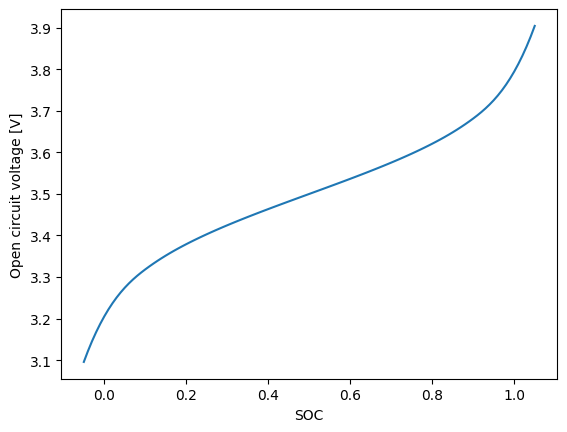

In [3]:
# They all use the same OCV; let's take a look at it
soc_vals = np.linspace(-0.05, 1.05, 111)
ocv = rint.asoh.OCV(soc=soc_vals)

plt.plot(soc_vals, ocv)
plt.ylabel('Open circuit voltage [V]')
plt.xlabel('SOC')

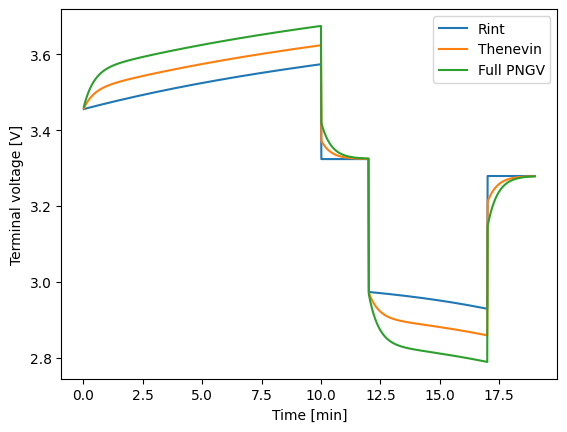

In [4]:
# Let's pretend we will charge the battery for 10 minutes with a current of 5 A,
# rest it for 2 minutes, discharge it for 5 minutes at a current of 7 A, and 
# finally rest it for another 2 minutes 
charge_time = 60 * 10
rest_time = 60 * 2
discharge_time = 60 * 5
time = np.arange(charge_time + rest_time + discharge_time + rest_time) + 1
time = time.tolist()
curr = [5] * charge_time
curr += [0] * rest_time
curr += [-7] * discharge_time
curr += [0] * rest_time
voltages = [[], [], []]
socs = [[], [], []]

# Charge
for i, t in enumerate(time):
    # Prepare new input
    new_input = ECMInput(time=t, current=curr[i])

    # Evolve transient state
    transients = [model.update_transient_state(new_input=new_input) \
                  for model in models]

    # Update transient state
    for transient, model, soc in zip(transients, models, socs):
        model.transient = transient.model_copy()
        soc += [transient.soc]

    # Set this in the ECM
    for model in models:
        model.previous_input = new_input.model_copy()

    # Get terminal voltage
    for volts, model in zip(voltages, models):
        volts += [model.calculate_terminal_voltage().terminal_voltage]

time = np.array(time) / 60  #back to minutes
plt.plot(time, voltages[0], label='Rint')
plt.plot(time, voltages[1], label='Thenevin')
plt.plot(time, voltages[2], label='Full PNGV')
plt.xlabel('Time [min]')
plt.ylabel('Terminal voltage [V]')
plt.legend()

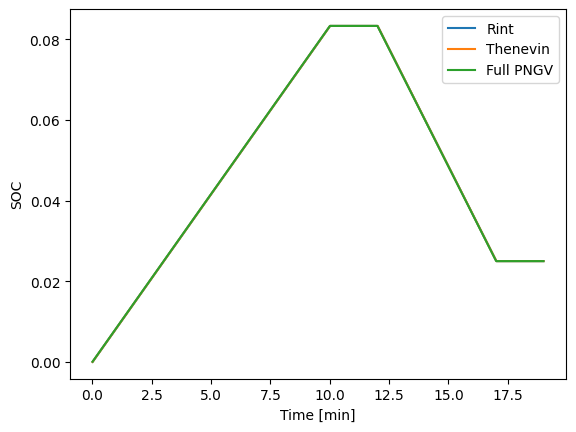

In [5]:
# Check SOCs are all the same
plt.plot(time, socs[0], label='Rint')
plt.plot(time, socs[1], label='Thenevin')
plt.plot(time, socs[2], label='Full PNGV')
plt.xlabel('Time [min]')
plt.ylabel('SOC')
plt.legend()